In [26]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

import numpy as np

In [29]:
sns.set_style("whitegrid")

sns.set(
    font_scale=1.5,
    rc={
        "font.family": "sans-serif",
        "font.size": 16.0,
        "figure.figsize": (11.69, 8.27),
    }
)

tqdm.pandas()

In [30]:
# Data directories
data_dir = Path("../data")

raw_dir = data_dir / "raw"
pubmed_dir = raw_dir / "pubmed"
scite_dir = raw_dir / "scite"

processed_dir = data_dir / "processed"

results_dir = data_dir / "results"

In [31]:
def article_profiles(dois:List, pattern:str="mentions_norm_mean", norm_refs=False, norm_eng=False, ax=None) -> None:
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    scores = {}
    for doi in tqdm(dois):
        pdf = citation_patterns[citation_patterns.target==doi].copy()
        pdf = pdf.sort_values(pattern)
        
        if norm_refs:
            pdf["x_perc"] = pdf[pattern].rank(method="first") - 1
            pdf["x_perc"] = pdf["x_perc"] / pdf["x_perc"].max()
        else:
            pdf["x_perc"] = pdf[pattern].rank(method="first")
            
        if norm_eng:
            pdf[pattern] = pdf[pattern] / pdf[pattern].max()
        
        sns.lineplot(data=pdf, x="x_perc", y=pattern, zorder=1, ax=ax)
        sns.scatterplot(data=pdf, x="x_perc", y=pattern, size="mentions", ax=ax,
                        sizes=(20,200), legend=False, zorder=2, palette="Set2")
        
    ax.set_title(f"{len(dois)} DOIs")
    ax.set_xlabel("Citing Articles")
    ax.set_ylabel("Relative Engagement");

## Load data

In [32]:
mention_patterns = pd.read_csv(processed_dir / "mention_patterns.csv", index_col=0)
citation_patterns = pd.read_csv(processed_dir / "citation_patterns.csv", index_col=0)
article_patterns = pd.read_csv(processed_dir / "article_patterns.csv", index_col=0)

<ipython-input-33-57e2afe99549>:1: RuntimeWarning: divide by zero encountered in log10
  pdf = np.log10(article_patterns).melt()


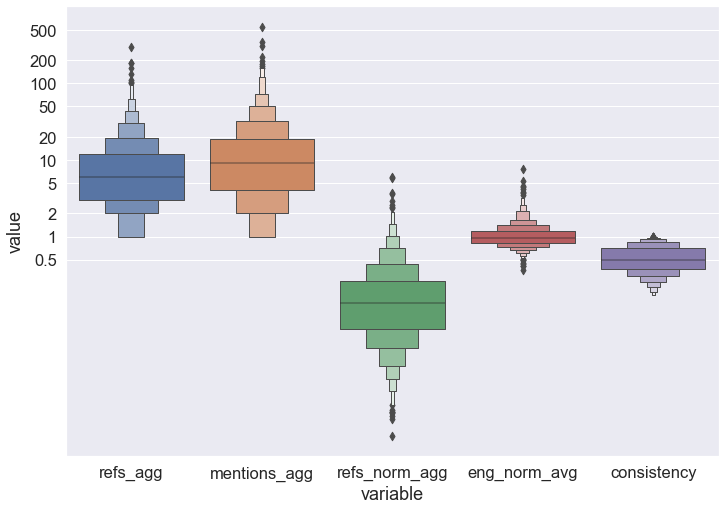

In [33]:
pdf = np.log10(article_patterns).melt()
sns.boxenplot(data=pdf, x="variable", y="value")

yticks = [.5, 1, 2, 5, 10, 20, 50, 100, 200, 500]
plt.yticks(ticks=np.log10(yticks), labels=yticks);

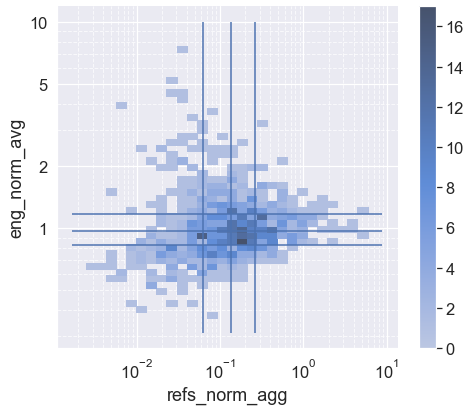

In [36]:
## Citations vs median weighted citation count
y = "eng_norm_avg"
x = "refs_norm_agg"
pdf = article_patterns
sns.displot(data=pdf, x=x, y=y,
            log_scale=(True, True), cbar=True, height=6, aspect=1.2)

plt.grid(True, which="minor", ls="--", alpha=.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

yticks = [1, 2, 5, 10]
plt.yticks(ticks=yticks, labels=yticks)
# xticks = [1,2,5,10, 20, 50, 100, 200, 500]
# plt.xticks(ticks=xticks, labels=xticks);

x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([article_patterns[y].quantile([.25, .5, .75])], x0, x1)
plt.vlines([article_patterns[x].quantile([.25, .5, .75])], y0, y1)

In [38]:
dois = article_patterns[
    (article_patterns.refs_agg>=10) &
    (article_patterns.eng_norm_avg>=.5)
].sample(5).index

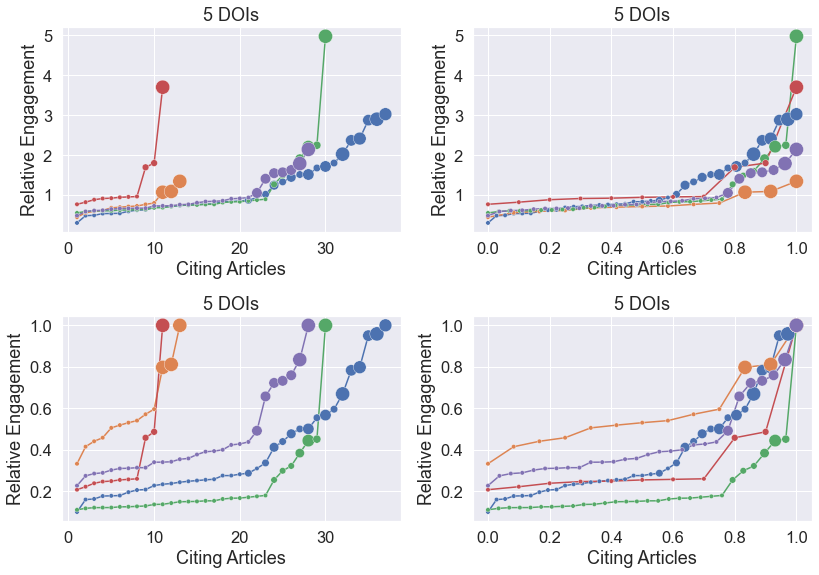

In [39]:
fig, axes = plt.subplots(2,2)

article_profiles(dois, norm_refs=False, ax=axes[0, 0])
article_profiles(dois, norm_refs=True, ax=axes[0, 1])
article_profiles(dois, norm_eng=True, ax=axes[1, 0])
article_profiles(dois, norm_refs=True, norm_eng=True, ax=axes[1, 1])

plt.tight_layout()

In [43]:
article_patterns.describe()

,refs_agg,mentions_agg,refs_norm_agg,eng_norm_avg,consistency
count,998.000000,998.000000,998.000000,998.000000,998.000000
mean,10.933868,17.905812,0.240949,1.079449,0.487036
std,18.486072,31.884495,0.416229,0.499001,0.265953
min,1.000000,1.000000,0.002513,0.363636,0.000000
25%,3.000000,4.000000,0.062509,0.828663,0.322304
50%,6.000000,9.000000,0.133779,0.969940,0.488198
75%,12.000000,19.000000,0.261283,1.177741,0.678664
max,299.000000,547.000000,5.946808,7.602674,1.000000


In [40]:
article_patterns.corr(method="spearman")

,refs_agg,mentions_agg,refs_norm_agg,eng_norm_avg,consistency
refs_agg,1.000000,0.934679,0.885814,0.235578,-0.182037
mentions_agg,0.934679,1.000000,0.832818,0.493607,-0.289309
refs_norm_agg,0.885814,0.832818,1.000000,0.212596,-0.168520
eng_norm_avg,0.235578,0.493607,0.212596,1.000000,-0.276103
consistency,-0.182037,-0.289309,-0.168520,-0.276103,1.000000


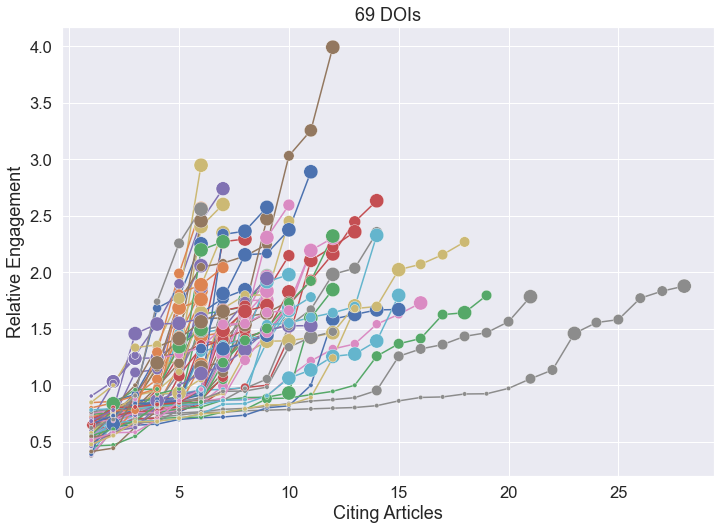

In [48]:
dois = article_patterns[
    (article_patterns.eng_norm_avg>=0.96) &
    (article_patterns.refs_agg>=6) &
    (article_patterns.consistency>=0.488)
].index

article_profiles(dois)

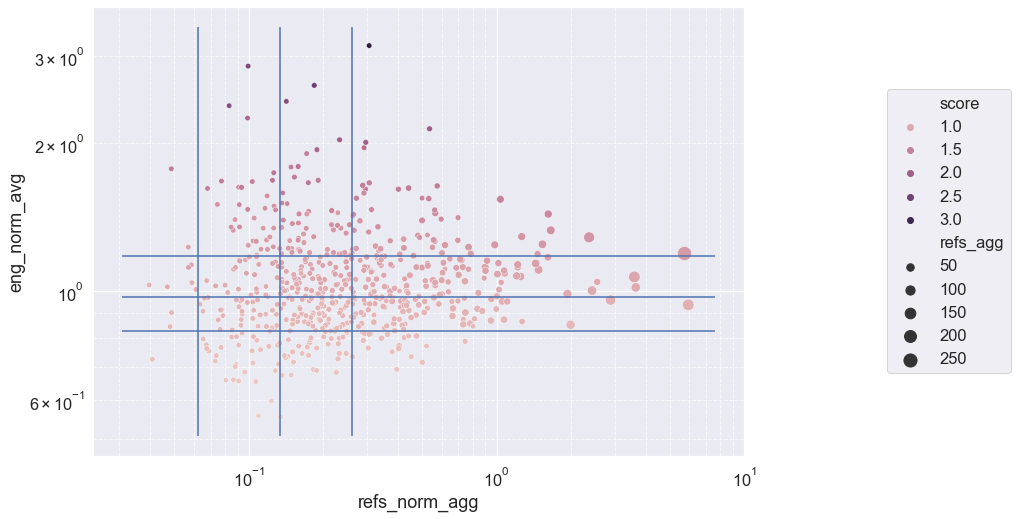

In [20]:
## Citations vs median weighted citation count
y = "eng_norm_avg"
x = "refs_norm_agg"

# pdf["wf1_agg_log"] = np.log10(pdf["wf1_agg"])

pdf = article_patterns[article_patterns.refs_agg>=5]

sns.scatterplot(data=pdf,
                y=y,
                x=x,
                size="refs_agg",
                hue="score", sizes=(30, 200)
               )
plt.legend(loc="right", bbox_to_anchor=(1.42, 0.5));

plt.grid(True, which="minor", ls="--", alpha=.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

# yticks = [1, 2, 5, 10, 20, 50, 100, 200]
# plt.yticks(ticks=yticks, labels=yticks)
# # xticks = [.5, 1,2,5,10]
# # plt.xticks(ticks=xticks, labels=xticks);

plt.loglog()

x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([article_patterns[y].quantile([.25, .5, .75])], x0, x1)
plt.vlines([article_patterns[x].quantile([.25, .5, .75])], y0, y1)

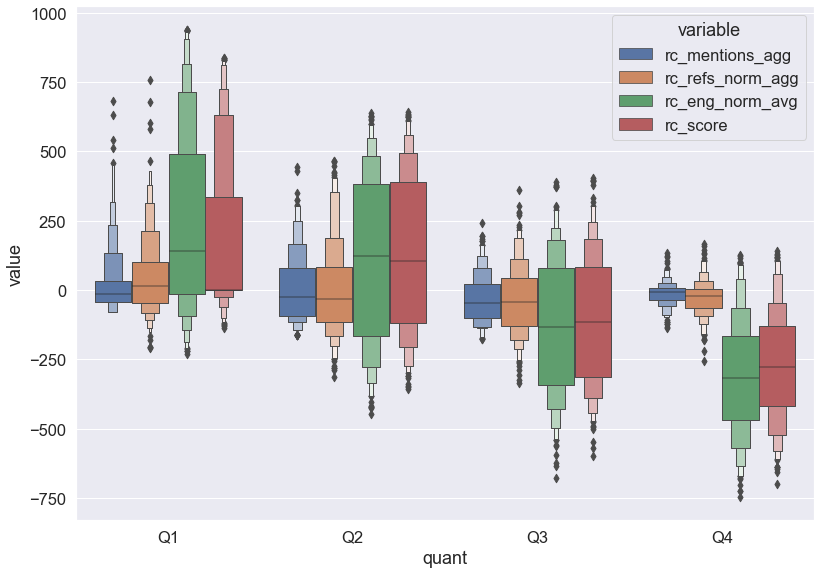

In [22]:
n_quantiles = 5
base_var = "refs_agg"
count_methods = ["mentions_agg", "refs_norm_agg", "eng_norm_avg", "score"]

df = article_patterns
df = df[[base_var] + count_methods].rank()
for cm in count_methods:
    df["rc_" + cm] = df[cm] - df[base_var]

labels = [f"Q{_}" for _ in range(1, n_quantiles)]

pdf = df.reset_index()
pdf = pdf.join(pd.qcut(pdf[base_var], n_quantiles-1, duplicates="drop", labels=labels).to_frame("quant"))
pdf = pdf.melt(id_vars=["quant", "index"], value_vars=["rc_" + cm for cm in count_methods])

sns.boxenplot(data=pdf, hue="variable", y="value", x="quant")
plt.tight_layout()